# Are some train routes more likely to experience delays than others? Visualize and proof statistically.

Load in data

In [1]:
import src.data_processing.data as data
import numpy as np
import pandas as pd


Explore the dataset to see if there are outliers regarding the delay time

In [2]:
trips = data.full_trips
stations = data.stations
provinces = data.provinces
trips[["Delay time"]].describe()

,Delay time
count,440943.000000
mean,122.892338
std,350.910273
min,0.000000
25%,0.000000
50%,31.000000
75%,123.000000
max,24536.000000


In [3]:
trips.sort_values(by = "Delay time" , ascending = False)

,Unnamed: 0,Date of departure,Train number,Relation,Railway operators,Railway of departure,Time of real arrival,Time of real departure,Time of planned arrival,Time of planned departure,Direction of relation,Name of the stop,Railway of arrival,Date of planned arrival,Date of planned departure,Date of real arrival,Date of real departure,Delay time
9689,9689,2020-09-22,1785,L B1-1,SNCB/NMBS,NaN,2020-09-22 21:19:56,NaT,2020-09-22 14:31:00,NaT,L B1-1: ANTWERPEN-CENTRAAL -> NIVELLES,vilvoorde,27,2020-09-22,NaT,2020-09-22,NaT,24536
61013,61013,2020-09-22,3485,L B7,SNCB/NMBS,NaN,2020-09-22 21:20:16,NaT,2020-09-22 14:36:00,NaT,L B7: MECHELEN -> HALLE,vilvoorde,27,2020-09-22,NaT,2020-09-22,NaT,24256
42349,42349,2020-09-21,324,INT,SNCB/NMBS,37,2020-09-21 14:42:47,2020-09-21 14:42:47,2020-09-21 08:50:00,2020-09-21 08:50:00,INT: WIEN HBF -> BRUSSEL-ZUID,hergenrath,37,2020-09-21,2020-09-21,2020-09-21,2020-09-21,21167
1335,1335,2020-09-21,324,INT,SNCB/NMBS,37,2020-09-21 14:46:53,2020-09-21 14:49:16,2020-09-21 08:56:00,2020-09-21 09:11:00,INT: WIEN HBF -> BRUSSEL-ZUID,welkenraedt,37,2020-09-21,2020-09-21,2020-09-21,2020-09-21,21053
42352,42352,2020-09-21,324,INT,SNCB/NMBS,37,2020-09-21 14:54:16,2020-09-21 14:54:16,2020-09-21 09:16:00,2020-09-21 09:16:00,INT: WIEN HBF -> BRUSSEL-ZUID,dolhain-gileppe,37,2020-09-21,2020-09-21,2020-09-21,2020-09-21,20296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45426,45426,2020-09-25,2440,IC 18,SNCB/NMBS,125,2020-09-25 19:07:37,2020-09-25 19:07:37,2020-09-25 19:08:00,2020-09-25 19:08:00,IC 18: LIEGE-SAINT-LAMBERT -> BRUSSEL-ZUID,amay,125,2020-09-25,2020-09-25,2020-09-25,2020-09-25,0
39932,39932,2020-09-22,1717,IC 14,SNCB/NMBS,96,2020-09-22 18:00:55,2020-09-22 18:00:55,2020-09-22 18:01:00,2020-09-22 18:01:00,IC 14: QUIEVRAIN -> LIEGE-GUILLEMINS,masnuy-saint-pierre,96,2020-09-22,2020-09-22,2020-09-22,2020-09-22,0
25814,25814,2020-09-26,537,IC 01,SNCB/NMBS,50A,2020-09-26 16:49:34,2020-09-26 16:49:34,2020-09-26 16:51:00,2020-09-26 16:51:00,IC 01: EUPEN -> OOSTENDE,beernem,50A,2020-09-26,2020-09-26,2020-09-26,2020-09-26,0
45429,45429,2020-09-25,2440,IC 18,SNCB/NMBS,125,2020-09-25 19:11:37,2020-09-25 19:12:36,2020-09-25 19:12:00,2020-09-25 19:13:00,IC 18: LIEGE-SAINT-LAMBERT -> BRUSSEL-ZUID,huy,125,2020-09-25,2020-09-25,2020-09-25,2020-09-25,0


We delete all delay times > 85.000 seconds, which is equal to almost 24 hours and thus can be seen as 'impossible'.

In [4]:

trips = data.full_trips
for x in trips[['Delay time']]:
    trips.loc[trips[x] > 85000,x] = np.nan
trips[["Delay time"]].describe()

,Delay time
count,440943.000000
mean,122.892338
std,350.910273
min,0.000000
25%,0.000000
50%,31.000000
75%,123.000000
max,24536.000000


We assume that a train route is an array of subsequent train stops

In [5]:
train_numbers = trips["Train number"].unique()
#routes is a dictionary that takes the train number as key and returns all the subsequent stop this train has passed through
routes = {}
for train_number in train_numbers:
    routes[train_number] = trips[trips["Train number"] == train_number].sort_values(by= [ "Time of real departure"])

In [6]:
#routes_by_day does the same as routes, but groups it by date of departure
routes_by_day = {}
for train_number in train_numbers:
    routes_by_day[train_number] = [group for _, group in routes[train_number].groupby("Date of departure")]


In [7]:
print(len(routes_by_day.get(10))) # for example this train rode on 7 different days
print(len(routes_by_day.get(12))) # while this one only rode on 6 different days

7
6


We can calculate the percentage of delays per day, per route

In [8]:
percentage_of_delays = {}
for train_number in train_numbers:
    percentage_of_delays[train_number] = []
    for day in routes_by_day.get(train_number):
        percentage_of_delays.get(train_number).append(day[day["Delay time"] > 0].shape[0] / day.shape[0])

On the first day, all stops of the route experienced a delay, the second day only 10% of the stops had a delay etc.

In [9]:
percentage_of_delays.get(10)

[1.0, 0.1, 0.25, 1.0, 1.0, 0.85, 0.0]

Indeed we see that for 2020-09-20, every stop had a Delay time >0

In [10]:
routes.get(10)[routes.get(10)["Date of departure"] == "2020-09-20"][["Date of departure", "Delay time"]]

,Date of departure,Delay time
13572,2020-09-20,450.0
13575,2020-09-20,470.0
14842,2020-09-20,463.0
14845,2020-09-20,425.0
14848,2020-09-20,354.0
14851,2020-09-20,240.0
14854,2020-09-20,183.0
14042,2020-09-20,132.0
14857,2020-09-20,132.0
14860,2020-09-20,132.0


Now we can calculate the average percentage of delays per route

In [11]:
average_percentage_of_delays = {}
for train_number in train_numbers:
    average_percentage_of_delays[train_number] = sum(percentage_of_delays.get(train_number)) / len(percentage_of_delays.get(train_number))

On average, 60% of the stops of route 10 experience delays.

In [12]:
average_percentage_of_delays.get(10)

0.6

We put this dictionary in a dataframe and add the direction of relation, so we can get a better indication of the route

In [13]:
average_percentage_of_delays_df = pd.DataFrame.from_dict(average_percentage_of_delays, orient ="index").reset_index().rename(columns = {"index": "Route", 0: "Delay_frequency"})
average_percentage_of_delays_df["Direction of relation"]  = average_percentage_of_delays_df.reset_index()["Route"].apply(lambda x: routes.get(x)["Direction of relation"].iloc[0])
average_percentage_of_delays_df

,Route,Delay_frequency,Direction of relation
0,11,0.816667,ICE: BRUSSEL-ZUID -> FRANKFURT(MAIN) HBF
1,116,0.380952,IC 33: LIERS -> LUXEMBOURG
2,110,0.585034,IC 33: LIERS -> LUXEMBOURG
3,112,0.435374,IC 33: LIERS -> LUXEMBOURG
4,113,0.551020,IC 33: LUXEMBOURG -> LIERS
...,...,...,...
4362,17204,0.941176,NaN
4363,17206,0.928571,NaN
4364,17209,0.975000,NaN
4365,9372,0.500000,THAL:BRUSSEL-ZUID -> PARIS-NORD


Descriptive analysis

In [14]:
average_percentage_of_delays_df["Delay_frequency"].describe()

count    4367.000000
mean        0.606082
std         0.211340
min         0.000000
25%         0.500000
50%         0.640674
75%         0.754637
max         1.000000
Name: Delay_frequency, dtype: float64

We plot a histogram of the "Delay_frequency"

<AxesSubplot: ylabel='Frequency'>

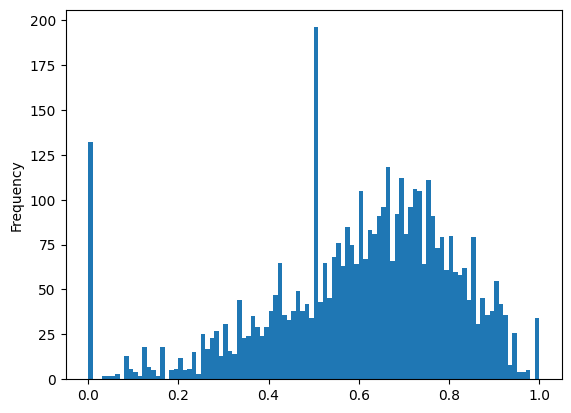

In [15]:
average_percentage_of_delays_df["Delay_frequency"].plot.hist(bins = 100)

Now we plot the same thing but cumulatively

<AxesSubplot: ylabel='Frequency'>

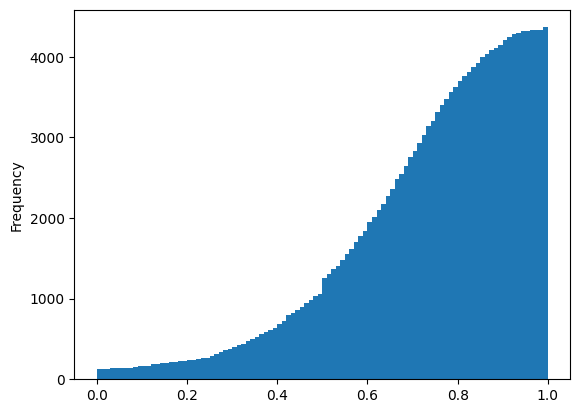

In [16]:
average_percentage_of_delays_df["Delay_frequency"].plot.hist(cumulative = True, bins = 100)

Intriguing that train routes that have a delay frequency of 100% are not considered outliers (the train is always late in this route).


In [17]:
def get_outlier(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    outlier = df[(df[column] > q3 + 1.5 * iqr) | (df[column] < q1 - 1.5 * iqr)]
    return outlier

outliers = get_outlier(average_percentage_of_delays_df, "Delay_frequency")
outliers


,Route,Delay_frequency,Direction of relation
66,4068,0.033333,L 31: JURBISE -> BRAINE-LE-COMTE
76,4081,0.033333,L 31: BRAINE-LE-COMTE -> JURBISE
88,4080,0.066667,L 31: BRAINE-LE-COMTE -> JURBISE
94,4083,0.100000,L 31: BRAINE-LE-COMTE -> JURBISE
305,19714,0.095238,IC 04-2: KORTRIJK -> LILLE FLANDRES
...,...,...,...
4254,19212,0.000000,IC 42: QUEVY-FRONTIERE -> MONS
4323,12743,0.090909,NaN
4351,19706,0.000000,IC 04-2: KORTRIJK -> LILLE FLANDRES
4352,19705,0.000000,IC 04-2: LILLE FLANDRES -> KORTRIJK


All non-outliers are thus more likely to experience delays

In [18]:
def get_diff(df1, df2):
    return df1.merge(df2, indicator=True, how='outer').loc[lambda x : x['_merge']=='left_only']
more_likely_to_experience_delays = get_diff(average_percentage_of_delays_df, outliers).drop(columns=['_merge'])
more_likely_to_experience_delays

,Route,Delay_frequency,Direction of relation
0,11,0.816667,ICE: BRUSSEL-ZUID -> FRANKFURT(MAIN) HBF
1,116,0.380952,IC 33: LIERS -> LUXEMBOURG
2,110,0.585034,IC 33: LIERS -> LUXEMBOURG
3,112,0.435374,IC 33: LIERS -> LUXEMBOURG
4,113,0.551020,IC 33: LUXEMBOURG -> LIERS
...,...,...,...
4362,17204,0.941176,NaN
4363,17206,0.928571,NaN
4364,17209,0.975000,NaN
4365,9372,0.500000,THAL:BRUSSEL-ZUID -> PARIS-NORD


# We set a threshold of 60 seconds before something will be counted as a delay.

Now we will see a lot more reasonable results

In [19]:
percentage_of_delays = {}
for train_number in train_numbers:
    percentage_of_delays[train_number] = []
    for day in routes_by_day.get(train_number):
        # change the day["Delay time"] > x value
        percentage_of_delays.get(train_number).append(day[day["Delay time"] > 59].shape[0] / day.shape[0])

average_percentage_of_delays = {}
for train_number in train_numbers:
    average_percentage_of_delays[train_number] = sum(percentage_of_delays.get(train_number)) / len(percentage_of_delays.get(train_number))

average_percentage_of_delays_df = pd.DataFrame.from_dict(average_percentage_of_delays,
                                                         orient="index").reset_index().rename(
    columns={"index": "Route", 0: "Delay_frequency"})
average_percentage_of_delays_df["Direction of relation"] = average_percentage_of_delays_df.reset_index()["Route"].apply(
    lambda x: routes.get(x)["Direction of relation"].iloc[0])
average_percentage_of_delays_df


,Route,Delay_frequency,Direction of relation
0,11,0.500000,ICE: BRUSSEL-ZUID -> FRANKFURT(MAIN) HBF
1,116,0.122449,IC 33: LIERS -> LUXEMBOURG
2,110,0.326531,IC 33: LIERS -> LUXEMBOURG
3,112,0.217687,IC 33: LIERS -> LUXEMBOURG
4,113,0.258503,IC 33: LUXEMBOURG -> LIERS
...,...,...,...
4362,17204,0.941176,NaN
4363,17206,0.928571,NaN
4364,17209,0.975000,NaN
4365,9372,0.500000,THAL:BRUSSEL-ZUID -> PARIS-NORD


In [20]:
average_percentage_of_delays_df["Delay_frequency"].describe()

count    4367.000000
mean        0.344652
std         0.216009
min         0.000000
25%         0.187500
50%         0.331868
75%         0.489403
max         1.000000
Name: Delay_frequency, dtype: float64

<AxesSubplot: ylabel='Frequency'>

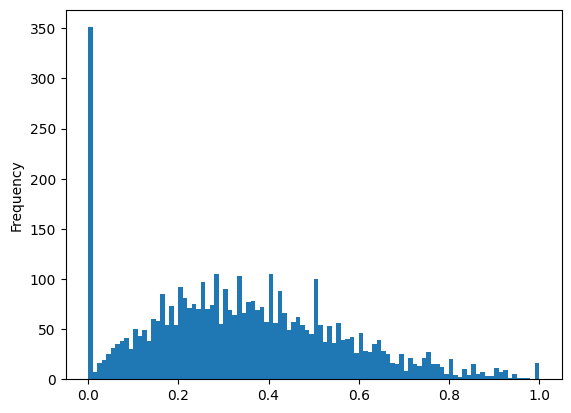

In [21]:
average_percentage_of_delays_df["Delay_frequency"].plot.hist(bins = 100)

<AxesSubplot: ylabel='Frequency'>

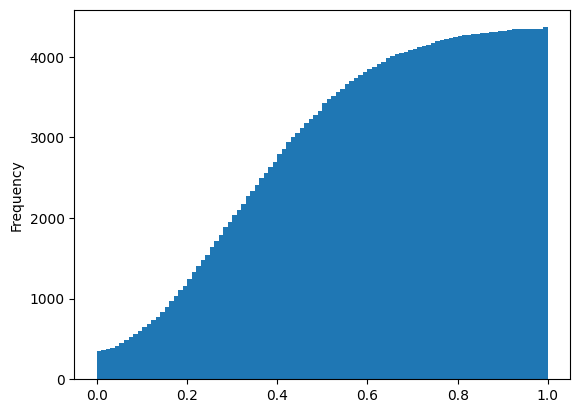

In [22]:
average_percentage_of_delays_df["Delay_frequency"].plot.hist(cumulative = True, bins = 100)

In [23]:
average_percentage_of_delays_df.describe()

,Route,Delay_frequency
count,4367.000000,4367.000000
mean,5255.034578,0.344652
std,4182.633734,0.216009
min,10.000000,0.000000
25%,2477.500000,0.187500
50%,4161.000000,0.331868
75%,6492.500000,0.489403
max,19979.000000,1.000000


Now we see that the higher delay_frequency are considered abnormal

In [24]:
import scipy.stats as stats
def calculate_z_score(df, column):
    df["z_score"] = (df[column] - df[column].mean()) / df[column].std(ddof=0)
    return df
def calculate_p_value(df):
    df["p_value"] = stats.norm.sf(abs(df["z_score"])) * 2
    return df

calculate_z_score(average_percentage_of_delays_df, "Delay_frequency")
calculate_p_value(average_percentage_of_delays_df)
average_percentage_of_delays_df

,Route,Delay_frequency,Direction of relation,z_score,p_value
0,11,0.500000,ICE: BRUSSEL-ZUID -> FRANKFURT(MAIN) HBF,0.719253,0.471985
1,116,0.122449,IC 33: LIERS -> LUXEMBOURG,-1.028794,0.303577
2,110,0.326531,IC 33: LIERS -> LUXEMBOURG,-0.083903,0.933133
3,112,0.217687,IC 33: LIERS -> LUXEMBOURG,-0.587845,0.556636
4,113,0.258503,IC 33: LUXEMBOURG -> LIERS,-0.398867,0.689991
...,...,...,...,...,...
4362,17204,0.941176,NaN,2.761884,0.005747
4363,17206,0.928571,NaN,2.703523,0.006861
4364,17209,0.975000,NaN,2.918486,0.003517
4365,9372,0.500000,THAL:BRUSSEL-ZUID -> PARIS-NORD,0.719253,0.471985


Routes that go to Brussel zuid, arlon, namur, vilvoorde, tournai : high chance of delay

In [26]:
average_percentage_of_delays_df[average_percentage_of_delays_df["p_value"] <0.05]

,Route,Delay_frequency,Direction of relation,z_score,p_value
11,1706,0.773305,IC 14: QUIEVRAIN -> LIEGE-GUILLEMINS,1.984643,0.047184
196,2128,0.791980,IC 16-1: LUXEMBOURG -> BRUSSEL-ZUID,2.071110,0.038349
208,2129,0.802189,IC 16-1: LUXEMBOURG -> BRUSSEL-ZUID,2.118379,0.034143
220,2133,0.771709,IC 16-1: LUXEMBOURG -> BRUSSEL-ZUID,1.977254,0.048013
234,1555,0.855172,L B6: AALST -> SCHAARBEEK,2.363688,0.018094
...,...,...,...,...,...
4357,9357,0.894737,THAL:PARIS-NORD -> AMSTERDAM CENTRAAL,2.546870,0.010869
4361,17202,0.857143,NaN,2.372812,0.017653
4362,17204,0.941176,NaN,2.761884,0.005747
4363,17206,0.928571,NaN,2.703523,0.006861


At 5% significance level, the routes below are more likely to experience delays.

In [27]:
average_percentage_of_delays_df[average_percentage_of_delays_df["p_value"] <0.05]["Direction of relation"].unique()

array(['IC 14: QUIEVRAIN -> LIEGE-GUILLEMINS',
       'IC 16-1: LUXEMBOURG -> BRUSSEL-ZUID', 'L B6: AALST -> SCHAARBEEK',
       'L B4: AALST -> VILVOORDE', nan,
       'L B8-1: LOUVAIN-LA-NEUVE -> BRUSSEL-ZUID',
       'L 26: LA LOUVIERE-SUD -> MONS',
       'IC 19-2: LILLE FLANDRES -> TOURNAI',
       'IC 07: ANTWERPEN-NOORDERDOKKEN -> CHARLEROI-SUD',
       'IC 42: MONS -> QUEVY-FRONTIERE',
       'L B8-4: BRUSSEL-ZUID -> OTTIGNIES', 'L 15: LIERS -> MARLOIE',
       'L B8-4: OTTIGNIES -> BRUSSEL-ZUID',
       'THAL:AMSTERDAM CENTRAAL -> PARIS-NORD',
       'L 11: NAMUR -> LIBRAMONT', 'L 11: LIBRAMONT -> NAMUR',
       'L 08: OTTIGNIES -> NAMUR', 'IC 19-1: TOURNAI -> NAMUR',
       'L 12: LUXEMBOURG -> ARLON', 'L C3: CHARLEROI-SUD -> ERQUELINNES',
       'IC 01: EUPEN -> OOSTENDE', 'IC 19-1: NAMUR -> TOURNAI',
       'THAL:KOLN HBF -> PARIS-NORD',
       'L L3: MAASTRICHT -> LIEGE-GUILLEMINS',
       'L L2: LIERS -> FLEMALLE-HAUTE',
       'IC 18: LIEGE-SAINT-LAMBERT -> BRUSSEL-ZUID'

We do the same equation but for the outliers to get a smaller subset of the result above

In [28]:
outliers = get_outlier(average_percentage_of_delays_df, "Delay_frequency")
outliers

,Route,Delay_frequency,Direction of relation,z_score,p_value
741,19945,1.000000,IC 19-2: LILLE FLANDRES -> TOURNAI,3.034235,0.002411
1032,8678,1.000000,NaN,3.034235,0.002411
1067,8677,1.000000,NaN,3.034235,0.002411
1542,5837,1.000000,L 12: LUXEMBOURG -> ARLON,3.034235,0.002411
2346,3979,0.945029,L B8-1: LOUVAIN-LA-NEUVE -> BRUSSEL-ZUID,2.779722,0.005441
3070,6579,0.943791,L B8-4: OTTIGNIES -> BRUSSEL-ZUID,2.773989,0.005537
3348,5834,1.000000,L 12: LUXEMBOURG -> ARLON,3.034235,0.002411
3363,5827,1.000000,L 12: LUXEMBOURG -> ARLON,3.034235,0.002411
3380,5830,1.000000,L 12: LUXEMBOURG -> ARLON,3.034235,0.002411
3413,5832,1.000000,L 12: LUXEMBOURG -> ARLON,3.034235,0.002411


We can plot these on a map aswell

In [37]:
routes_by_day_with_coordinates = {}
stations["name"] = stations["name"].str.lower()
for train_number in train_numbers:
    routes_by_day_with_coordinates[train_number] = []
    for route in routes_by_day[train_number]:
        routes_by_day_with_coordinates[train_number].append(route.merge(stations, left_on="Name of the stop", right_on ="name"))

,URI,name,country-code,longitude,latitude,avg_stop_times,official_transfer_time
3,008895000,Aalst,be,4.039653,50.942813,157.425373,300.0
4,008895125,Aalst-Kerrebroek,be,4.024407,50.948377,7.731343,300.0
5,008891140,Aalter,be,3.447848,51.092295,188.276119,240.0
6,008833209,Aarschot,be,4.824043,50.984406,171.664179,240.0
7,008892288,Aarsele,be,3.418363,50.984460,37.365672,300.0
...,...,...,...,...,...,...,...
669,008832250,Zolder,be,5.329900,51.033548,30.910448,300.0
670,008832334,Zonhoven,be,5.348815,50.989557,30.910448,300.0
671,008895208,Zottegem,be,3.814410,50.869102,161.223881,240.0
673,008894821,Zwijndrecht,be,4.329780,51.214108,150.514925,300.0


Routes that have more chance to have delays, in general

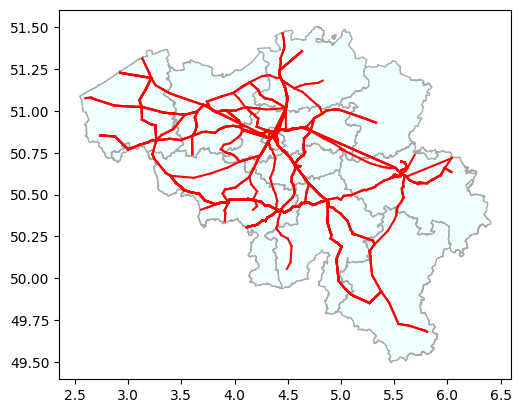

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
data.provinces.plot(ax=ax, color = "#F0FFFF", edgecolor = "darkgrey")
delay_routes = average_percentage_of_delays_df[average_percentage_of_delays_df["p_value"] <0.05]["Route"].unique()
for delay_route in delay_routes:
    plt.plot([routes_by_day_with_coordinates.get(delay_route)[0].iloc[:-1]["longitude"], routes_by_day_with_coordinates.get(delay_route)[0].iloc[1:]["longitude"]], [routes_by_day_with_coordinates.get(delay_route)[0].iloc[:-1]["latitude"], routes_by_day_with_coordinates.get(delay_route)[0].iloc[1:]["latitude"]], color = "red")

Outlier delay routes

Routes around brussels, to the coast

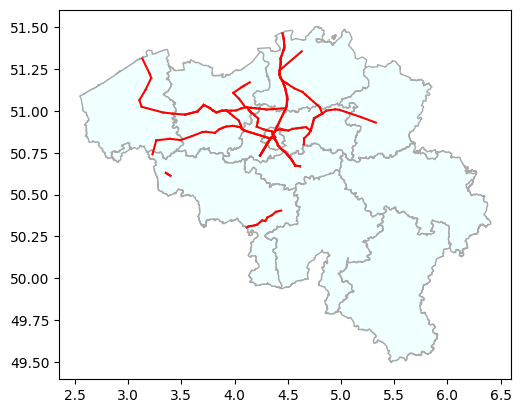

In [40]:
fig, ax = plt.subplots()
data.provinces.plot(ax=ax, color = "#F0FFFF", edgecolor = "darkgrey")
outlier_delay_routes = get_outlier(average_percentage_of_delays_df, "Delay_frequency")["Route"]
for delay_route in outlier_delay_routes:
    plt.plot([routes_by_day_with_coordinates.get(delay_route)[0].iloc[:-1]["longitude"], routes_by_day_with_coordinates.get(delay_route)[0].iloc[1:]["longitude"]], [routes_by_day_with_coordinates.get(delay_route)[0].iloc[:-1]["latitude"], routes_by_day_with_coordinates.get(delay_route)[0].iloc[1:]["latitude"]], color = "red")

In [41]:
average_percentage_of_delays_df

,Route,Delay_frequency,Direction of relation,z_score,p_value
0,11,0.500000,ICE: BRUSSEL-ZUID -> FRANKFURT(MAIN) HBF,0.719253,0.471985
1,116,0.122449,IC 33: LIERS -> LUXEMBOURG,-1.028794,0.303577
2,110,0.326531,IC 33: LIERS -> LUXEMBOURG,-0.083903,0.933133
3,112,0.217687,IC 33: LIERS -> LUXEMBOURG,-0.587845,0.556636
4,113,0.258503,IC 33: LUXEMBOURG -> LIERS,-0.398867,0.689991
...,...,...,...,...,...
4362,17204,0.941176,NaN,2.761884,0.005747
4363,17206,0.928571,NaN,2.703523,0.006861
4364,17209,0.975000,NaN,2.918486,0.003517
4365,9372,0.500000,THAL:BRUSSEL-ZUID -> PARIS-NORD,0.719253,0.471985


# From here on, we will do some extra analysis

# 0. Plot all the routes <20% delay in green, 20-50% delay in orange, 50%> in red



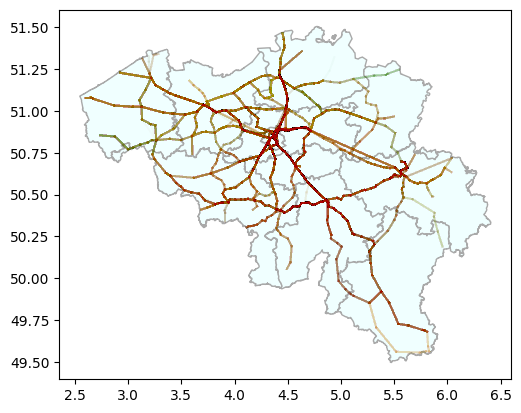

In [53]:
fig, ax = plt.subplots()
data.provinces.plot(ax=ax, color = "#F0FFFF", edgecolor = "darkgrey")
for train_number in train_numbers:
      if average_percentage_of_delays_df[average_percentage_of_delays_df["Route"] == train_number]["Delay_frequency"].iloc[0] > 0.5:
        plt.plot([routes_by_day_with_coordinates.get(train_number)[0].iloc[:-1]["longitude"], routes_by_day_with_coordinates.get(train_number)[0].iloc[1:]["longitude"]], [routes_by_day_with_coordinates.get(train_number)[0].iloc[:-1]["latitude"], routes_by_day_with_coordinates.get(train_number)[0].iloc[1:]["latitude"]], color = "red", zorder = 3, alpha =0.01)

      if (average_percentage_of_delays_df[average_percentage_of_delays_df["Route"] == train_number]["Delay_frequency"].iloc[0] > 0.2) & (average_percentage_of_delays_df[average_percentage_of_delays_df["Route"] == train_number]["Delay_frequency"].iloc[0] <= 0.5):
        plt.plot([routes_by_day_with_coordinates.get(train_number)[0].iloc[:-1]["longitude"], routes_by_day_with_coordinates.get(train_number)[0].iloc[1:]["longitude"]], [routes_by_day_with_coordinates.get(train_number)[0].iloc[:-1]["latitude"], routes_by_day_with_coordinates.get(train_number)[0].iloc[1:]["latitude"]], color = "orange", zorder = 2, alpha =0.01)

      else:plt.plot([routes_by_day_with_coordinates.get(train_number)[0].iloc[:-1]["longitude"], routes_by_day_with_coordinates.get(train_number)[0].iloc[1:]["longitude"]], [routes_by_day_with_coordinates.get(train_number)[0].iloc[:-1]["latitude"], routes_by_day_with_coordinates.get(train_number)[0].iloc[1:]["latitude"]], color = "green", zorder =1, alpha = 0.01)



# 1. Does the amount of stops in a route affect the delay frequency / time?

In [54]:
train_stops_per_route = {}
for train_number in train_numbers:
        train_stops_per_route[train_number] = routes_by_day.get(train_number)[0].shape[0]
train_stops_per_route.get(10)

20

Now we see that Luxembourg -> Arlon that we got from the first question, only has 1 stop. But still a delay frequency of 100%.

The lower the delay_frequency/ number of stops, the better

In [55]:
stops_and_delay_frequency = average_percentage_of_delays_df.copy()
stops_and_delay_frequency["number of stops"] = stops_and_delay_frequency["Route"].apply(
    lambda x: train_stops_per_route.get(x))
stops_and_delay_frequency["Delay_frequency / number of stops"] = stops_and_delay_frequency["Delay_frequency"] / stops_and_delay_frequency["number of stops"]
stops_and_delay_frequency = stops_and_delay_frequency[['Route', 'Delay_frequency', 'number of stops', "Delay_frequency / number of stops", 'Direction of relation']]
stops_and_delay_frequency

,Route,Delay_frequency,number of stops,Delay_frequency / number of stops,Direction of relation
0,11,0.500000,20,0.025000,ICE: BRUSSEL-ZUID -> FRANKFURT(MAIN) HBF
1,116,0.122449,21,0.005831,IC 33: LIERS -> LUXEMBOURG
2,110,0.326531,21,0.015549,IC 33: LIERS -> LUXEMBOURG
3,112,0.217687,21,0.010366,IC 33: LIERS -> LUXEMBOURG
4,113,0.258503,21,0.012310,IC 33: LUXEMBOURG -> LIERS
...,...,...,...,...,...
4362,17204,0.941176,17,0.055363,NaN
4363,17206,0.928571,14,0.066327,NaN
4364,17209,0.975000,40,0.024375,NaN
4365,9372,0.500000,2,0.250000,THAL:BRUSSEL-ZUID -> PARIS-NORD


We see that there is a small positive correlation between delay frequency and number of stops.

In [56]:
stops_and_delay_frequency["Delay_frequency"].corr(stops_and_delay_frequency["number of stops"])

0.2667960346186545

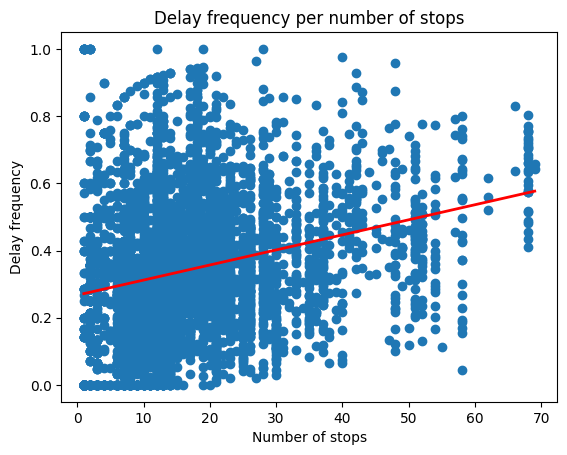

In [57]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
ax.scatter(stops_and_delay_frequency["number of stops"], stops_and_delay_frequency["Delay_frequency"])
ax.set_xlabel("Number of stops")
ax.set_ylabel("Delay frequency")
ax.set_title("Delay frequency per number of stops")
ax.plot(np.unique(stops_and_delay_frequency["number of stops"]), np.poly1d(np.polyfit(stops_and_delay_frequency["number of stops"], stops_and_delay_frequency["Delay_frequency"], 1))(np.unique(stops_and_delay_frequency["number of stops"])), color="red", linewidth=2)
plt.show()


# 2 How much delay does each route experience on average?

In [58]:
mean_delay_time = {}
for train_number in train_numbers:
    mean_delay_time[train_number] = routes.get(train_number)["Delay time"].mean()
mean_delay_time.get(10)

136.86428571428573

In [59]:
mean_delay_time_df = pd.DataFrame.from_dict(mean_delay_time,
                                            orient="index").reset_index().rename(
    columns={"index": "Route", 0: "Mean delay time"})
mean_delay_time_df["Direction of relation"] = mean_delay_time_df.reset_index()["Route"].apply(
    lambda x: routes.get(x)["Direction of relation"].iloc[0])
mean_delay_time_df

,Route,Mean delay time,Direction of relation
0,11,126.258333,ICE: BRUSSEL-ZUID -> FRANKFURT(MAIN) HBF
1,116,18.034014,IC 33: LIERS -> LUXEMBOURG
2,110,99.578231,IC 33: LIERS -> LUXEMBOURG
3,112,33.721088,IC 33: LIERS -> LUXEMBOURG
4,113,52.095238,IC 33: LUXEMBOURG -> LIERS
...,...,...,...
4362,17204,2485.470588,NaN
4363,17206,1387.000000,NaN
4364,17209,1342.250000,NaN
4365,9372,142.500000,THAL:BRUSSEL-ZUID -> PARIS-NORD


Check the 2 'extreme values' route 324 and 9095

In [60]:
routes.get(324)

,Unnamed: 0,Date of departure,Train number,Relation,Railway operators,Railway of departure,Time of real arrival,Time of real departure,Time of planned arrival,Time of planned departure,Direction of relation,Name of the stop,Railway of arrival,Date of planned arrival,Date of planned departure,Date of real arrival,Date of real departure,Delay time
42349,42349,2020-09-21,324,INT,SNCB/NMBS,37,2020-09-21 14:42:47,2020-09-21 14:42:47,2020-09-21 08:50:00,2020-09-21 08:50:00,INT: WIEN HBF -> BRUSSEL-ZUID,hergenrath,37,2020-09-21,2020-09-21,2020-09-21,2020-09-21,21167.0
1335,1335,2020-09-21,324,INT,SNCB/NMBS,37,2020-09-21 14:46:53,2020-09-21 14:49:16,2020-09-21 08:56:00,2020-09-21 09:11:00,INT: WIEN HBF -> BRUSSEL-ZUID,welkenraedt,37,2020-09-21,2020-09-21,2020-09-21,2020-09-21,21053.0
42352,42352,2020-09-21,324,INT,SNCB/NMBS,37,2020-09-21 14:54:16,2020-09-21 14:54:16,2020-09-21 09:16:00,2020-09-21 09:16:00,INT: WIEN HBF -> BRUSSEL-ZUID,dolhain-gileppe,37,2020-09-21,2020-09-21,2020-09-21,2020-09-21,20296.0
1338,1338,2020-09-21,324,INT,SNCB/NMBS,37,2020-09-21 14:57:17,2020-09-21 14:57:17,2020-09-21 09:22:00,2020-09-21 09:22:00,INT: WIEN HBF -> BRUSSEL-ZUID,verviers-palais,37,2020-09-21,2020-09-21,2020-09-21,2020-09-21,20117.0
61124,61124,2020-09-21,324,INT,SNCB/NMBS,37,2020-09-21 14:57:51,2020-09-21 14:57:51,2020-09-21 09:22:00,2020-09-21 09:22:00,INT: WIEN HBF -> BRUSSEL-ZUID,verviers-central,37,2020-09-21,2020-09-21,2020-09-21,2020-09-21,20151.0
1341,1341,2020-09-21,324,INT,SNCB/NMBS,37,2020-09-21 15:00:45,2020-09-21 15:00:45,2020-09-21 09:25:00,2020-09-21 09:25:00,INT: WIEN HBF -> BRUSSEL-ZUID,pepinster,37,2020-09-21,2020-09-21,2020-09-21,2020-09-21,20145.0
61127,61127,2020-09-21,324,INT,SNCB/NMBS,37,2020-09-21 15:03:57,2020-09-21 15:03:57,2020-09-21 09:30:00,2020-09-21 09:30:00,INT: WIEN HBF -> BRUSSEL-ZUID,fraipont,37,2020-09-21,2020-09-21,2020-09-21,2020-09-21,20037.0
1344,1344,2020-09-21,324,INT,SNCB/NMBS,37,2020-09-21 15:04:05,2020-09-21 15:04:05,2020-09-21 09:29:00,2020-09-21 09:29:00,INT: WIEN HBF -> BRUSSEL-ZUID,nessonvaux,37,2020-09-21,2020-09-21,2020-09-21,2020-09-21,20105.0
1347,1347,2020-09-21,324,INT,SNCB/NMBS,37,2020-09-21 15:06:57,2020-09-21 15:06:57,2020-09-21 09:33:00,2020-09-21 09:33:00,INT: WIEN HBF -> BRUSSEL-ZUID,olne,37,2020-09-21,2020-09-21,2020-09-21,2020-09-21,20037.0
42355,42355,2020-09-21,324,INT,SNCB/NMBS,37,2020-09-21 15:07:39,2020-09-21 15:07:39,2020-09-21 09:34:00,2020-09-21 09:34:00,INT: WIEN HBF -> BRUSSEL-ZUID,trooz,37,2020-09-21,2020-09-21,2020-09-21,2020-09-21,20019.0


In [61]:
routes.get(9095)

,Unnamed: 0,Date of departure,Train number,Relation,Railway operators,Railway of departure,Time of real arrival,Time of real departure,Time of planned arrival,Time of planned departure,Direction of relation,Name of the stop,Railway of arrival,Date of planned arrival,Date of planned departure,Date of real arrival,Date of real departure,Delay time
39096,39096,2020-09-20,9095,TGV,SNCB/NMBS,1,2020-09-20 12:14:45,2020-09-20 12:14:45,2020-09-20 10:53:00,2020-09-20 10:53:00,NaN,halle,1,2020-09-20,2020-09-20,2020-09-20,2020-09-20,4905.0
39656,39656,2020-09-20,9095,TGV,SNCB/NMBS,NaN,2020-09-20 12:23:55,NaT,2020-09-20 11:01:00,NaT,NaN,brussel-zuid/bruxelles-midi,96N,2020-09-20,NaT,2020-09-20,NaT,4975.0


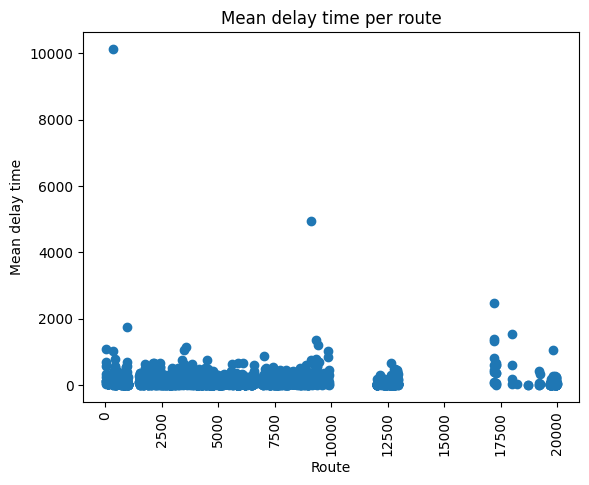

In [62]:
fig, ax = plt.subplots()
ax.scatter(mean_delay_time_df["Route"], mean_delay_time_df["Mean delay time"])
ax.set_xlabel("Route")
ax.set_ylabel("Mean delay time")
ax.set_title("Mean delay time per route")
plt.xticks(rotation=90)
plt.show()

The direction of relations with the most mean delay time

In [63]:
get_outlier(mean_delay_time_df,"Mean delay time").sort_values(by = "Mean delay time", ascending = False)["Direction of relation"].unique()

array(['INT: WIEN HBF -> BRUSSEL-ZUID', nan, 'IC 19-1: NAMUR -> TOURNAI',
       'THAL:AMSTERDAM CENTRAAL -> PARIS-NORD',
       'THAL:KOLN HBF -> PARIS-NORD', 'L B5-2: MECHELEN -> EDINGEN',
       'ICE: FRANKFURT(MAIN) HBF -> BRUSSEL-ZUID',
       'IC 41: ERQUELINNES-FRONTIERE -> NAMUR', 'L B7: MECHELEN -> HALLE',
       'TGV:MARSEILLE-SAINT-CHARLES -> BRUSSEL-ZUID',
       'IC 12: KORTRIJK -> WELKENRAEDT', 'IC 05: CHARLEROI-SUD -> ESSEN',
       'L B5-1: MECHELEN -> HALLE',
       'EURST:LONDON-ST-PANCRAS INTL -> BRUSSEL-ZUID',
       'THAL:PARIS-NORD -> AMSTERDAM CENTRAAL',
       'ICE: BRUSSEL-ZUID -> FRANKFURT(MAIN) HBF',
       'IC 16-1: BRUSSEL-ZUID -> LUXEMBOURG',
       'IC 18: LIEGE-SAINT-LAMBERT -> BRUSSEL-ZUID',
       'IC 16-1: LUXEMBOURG -> BRUSSEL-ZUID',
       'L 13-1: LIBRAMONT -> ARLON', 'L 11: NAMUR -> LIBRAMONT',
       'IC 25: MOESKROEN -> LIERS',
       'IC 35-1: AMSTERDAM CENTRAAL -> BRUSSEL-ZUID',
       'IC 14: LIEGE-GUILLEMINS -> QUIEVRAIN', 'L 15: MARLOIE -> 

# 3 Is there a relation between the delay frequency and average delay time?

Merge the mean delay time and average percentage of delays dataset

In [64]:
all = mean_delay_time_df.merge(average_percentage_of_delays_df, on = "Route")
all

,Route,Mean delay time,Direction of relation_x,Delay_frequency,Direction of relation_y,z_score,p_value
0,11,126.258333,ICE: BRUSSEL-ZUID -> FRANKFURT(MAIN) HBF,0.500000,ICE: BRUSSEL-ZUID -> FRANKFURT(MAIN) HBF,0.719253,0.471985
1,116,18.034014,IC 33: LIERS -> LUXEMBOURG,0.122449,IC 33: LIERS -> LUXEMBOURG,-1.028794,0.303577
2,110,99.578231,IC 33: LIERS -> LUXEMBOURG,0.326531,IC 33: LIERS -> LUXEMBOURG,-0.083903,0.933133
3,112,33.721088,IC 33: LIERS -> LUXEMBOURG,0.217687,IC 33: LIERS -> LUXEMBOURG,-0.587845,0.556636
4,113,52.095238,IC 33: LUXEMBOURG -> LIERS,0.258503,IC 33: LUXEMBOURG -> LIERS,-0.398867,0.689991
...,...,...,...,...,...,...,...
4362,17204,2485.470588,NaN,0.941176,NaN,2.761884,0.005747
4363,17206,1387.000000,NaN,0.928571,NaN,2.703523,0.006861
4364,17209,1342.250000,NaN,0.975000,NaN,2.918486,0.003517
4365,9372,142.500000,THAL:BRUSSEL-ZUID -> PARIS-NORD,0.500000,THAL:BRUSSEL-ZUID -> PARIS-NORD,0.719253,0.471985


Positive correlation on how likely a route is experience a delay, and how long that delay is!

In [65]:
all["Delay_frequency"].corr(all["Mean delay time"])

0.4016272519540321

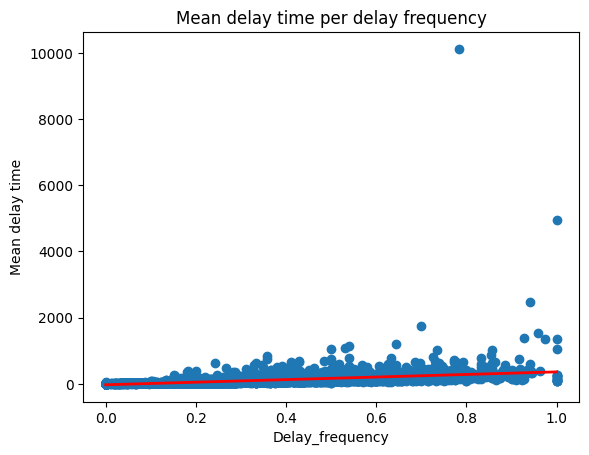

In [66]:
fig, ax = plt.subplots()
ax.scatter(all["Delay_frequency"], all["Mean delay time"])
ax.set_xlabel("Delay_frequency")
ax.set_ylabel("Mean delay time")
ax.set_title("Mean delay time per delay frequency")
ax.plot(np.unique(all["Delay_frequency"]), np.poly1d(np.polyfit(all["Delay_frequency"], all["Mean delay time"], 1))(np.unique(all["Delay_frequency"])), color="red", linewidth=2)


plt.show()

 # 4. Which are the most problematic routes?

Merge the routes that have the most mean delay time and most average percentage of delays.
These routes are the most problematic.

In [71]:
problematic_routes = get_outlier(mean_delay_time_df,"Mean delay time").merge(average_percentage_of_delays_df[average_percentage_of_delays_df["p_value"] <0.05], on = "Route")
problematic_routes = problematic_routes[['Route', 'Mean delay time', 'Delay_frequency', 'Direction of relation_x' ]]
problematic_routes

,Route,Mean delay time,Delay_frequency,Direction of relation_x
0,1706,319.265385,0.773305,IC 14: QUIEVRAIN -> LIEGE-GUILLEMINS
1,2128,670.421053,0.791980,IC 16-1: LUXEMBOURG -> BRUSSEL-ZUID
2,2129,300.099762,0.802189,IC 16-1: LUXEMBOURG -> BRUSSEL-ZUID
3,1555,342.268966,0.855172,L B6: AALST -> SCHAARBEEK
4,2187,303.215385,0.892308,L B4: AALST -> VILVOORDE
...,...,...,...,...
70,19812,278.000000,0.916667,IC 41: NAMUR -> ERQUELINNES-FRONTIERE
71,17202,392.000000,0.857143,NaN
72,17204,2485.470588,0.941176,NaN
73,17206,1387.000000,0.928571,NaN


In [72]:
for route in problematic_routes["Route"]:
    routes[route] = routes[route].merge(stations, left_on = "Name of the stop", right_on = "name")
routes.get(1706)

,Unnamed: 0,Date of departure,Train number,Relation,Railway operators,Railway of departure,Time of real arrival,Time of real departure,Time of planned arrival,Time of planned departure,...,Date of real arrival,Date of real departure,Delay time,URI,name,country-code,longitude,latitude,avg_stop_times,official_transfer_time
0,41070,2020-09-21,1706,IC 14,SNCB/NMBS,97,NaT,2020-09-21 06:13:23,NaT,2020-09-21 06:13:00,...,NaT,2020-09-21,0.0,008884335,quievrain,be,3.686080,50.410103,32.768657,300.0
1,1028,2020-09-22,1706,IC 14,SNCB/NMBS,97,NaT,2020-09-22 06:17:21,NaT,2020-09-22 06:13:00,...,NaT,2020-09-22,0.0,008884335,quievrain,be,3.686080,50.410103,32.768657,300.0
2,5275,2020-09-23,1706,IC 14,SNCB/NMBS,97,NaT,2020-09-23 06:13:01,NaT,2020-09-23 06:13:00,...,NaT,2020-09-23,0.0,008884335,quievrain,be,3.686080,50.410103,32.768657,300.0
3,6235,2020-09-25,1706,IC 14,SNCB/NMBS,97,NaT,2020-09-25 06:13:46,NaT,2020-09-25 06:13:00,...,NaT,2020-09-25,0.0,008884335,quievrain,be,3.686080,50.410103,32.768657,300.0
4,51607,2020-09-21,1706,IC 14,SNCB/NMBS,97,2020-09-21 06:18:23,2020-09-21 06:20:11,2020-09-21 06:18:00,2020-09-21 06:18:00,...,2020-09-21,2020-09-21,23.0,008884350,thulin,be,3.744708,50.423335,32.768657,300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,327,2020-09-22,1706,IC 14,SNCB/NMBS,NaN,2020-09-22 09:15:05,NaT,2020-09-22 09:06:00,NaT,...,2020-09-22,NaT,545.0,008841004,liège-guillemins,be,5.566695,50.624550,451.537313,300.0
246,5585,2020-09-23,1706,IC 14,SNCB/NMBS,NaN,2020-09-23 09:11:48,NaT,2020-09-23 09:06:00,NaT,...,2020-09-23,NaT,348.0,008841004,liège-guillemins,be,5.566695,50.624550,451.537313,300.0
247,41109,2020-09-21,1706,IC 14,SNCB/NMBS,NaN,2020-09-21 09:09:27,NaT,2020-09-21 09:06:00,NaT,...,2020-09-21,NaT,207.0,008841004,liège-guillemins,be,5.566695,50.624550,451.537313,300.0
248,5177,2020-09-25,1706,IC 14,SNCB/NMBS,NaN,2020-09-25 09:08:37,NaT,2020-09-25 09:06:00,NaT,...,2020-09-25,NaT,157.0,008841004,liège-guillemins,be,5.566695,50.624550,451.537313,300.0


In [73]:
problematic_routes

,Route,Mean delay time,Delay_frequency,Direction of relation_x
0,1706,319.265385,0.773305,IC 14: QUIEVRAIN -> LIEGE-GUILLEMINS
1,2128,670.421053,0.791980,IC 16-1: LUXEMBOURG -> BRUSSEL-ZUID
2,2129,300.099762,0.802189,IC 16-1: LUXEMBOURG -> BRUSSEL-ZUID
3,1555,342.268966,0.855172,L B6: AALST -> SCHAARBEEK
4,2187,303.215385,0.892308,L B4: AALST -> VILVOORDE
...,...,...,...,...
70,19812,278.000000,0.916667,IC 41: NAMUR -> ERQUELINNES-FRONTIERE
71,17202,392.000000,0.857143,NaN
72,17204,2485.470588,0.941176,NaN
73,17206,1387.000000,0.928571,NaN


Plot the most problematic routes on the map

In [74]:
problematic_routes_stops = {}
for route in problematic_routes["Route"]:
    problematic_routes_stops[route] = routes.get(route)["Name of the stop"].value_counts()
    problematic_routes_stops[route] = problematic_routes_stops[route].reset_index().rename(columns={"index": "Name of the stop", "Name of the stop": "count"})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


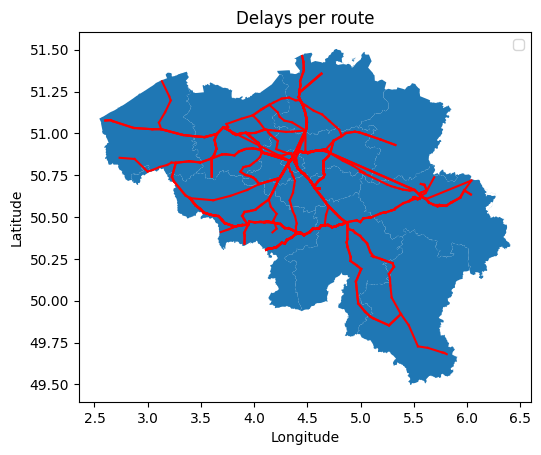

In [75]:
fig, ax = plt.subplots()
data.provinces.plot(ax=ax)
for route in problematic_routes["Route"]:
    # if problematic_routes[problematic_routes["Route"] == route]["Mean delay time"].iloc[0] > 700:
       ax.plot([routes_by_day_with_coordinates.get(route)[0].iloc[:-1]["longitude"], routes_by_day_with_coordinates.get(route)[0].iloc[1:]["longitude"]], [routes_by_day_with_coordinates.get(route)[0].iloc[:-1]["latitude"], routes_by_day_with_coordinates.get(route)[0].iloc[1:]["latitude"]], color = "red")

    # else:  ax.plot([routes_by_day_with_coordinates.get(route)[0].iloc[:-1]["longitude"], routes_by_day_with_coordinates.get(route)[0].iloc[1:]["longitude"]], [routes_by_day_with_coordinates.get(route)[0].iloc[:-1]["latitude"], routes_by_day_with_coordinates.get(route)[0].iloc[1:]["latitude"]], color = "green")


    #  ax.plot(routes[route]["longitude_x"].iloc[1:], routes[route]["latitude_x"].iloc[1:], color = "red")
    # else: ax.plot(routes[route]["longitude_x"].iloc[1:], routes[route]["latitude_x"].iloc[1:], color = "green")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Delays per route")
plt.legend()
plt.show()


Which stations are these?

We see that all stops in Brussels are the most problematic

In [76]:
problematic_routes_stops = {}
for route in problematic_routes["Route"]:
    problematic_routes_stops[route] = routes.get(route)["Name of the stop"].value_counts()
    problematic_routes_stops[route] = problematic_routes_stops[route].reset_index().rename(columns={"index": "Name of the stop", "Name of the stop": "count"})
problematic_routes_stops_df = pd.concat(problematic_routes_stops.values())
problematic_routes_stops_df = problematic_routes_stops_df.groupby("Name of the stop").sum().reset_index().sort_values(by = "count",ascending =False)
problematic_routes_stops_df

,Name of the stop,count
64,brussel-zuid/bruxelles-midi,167
60,brussel-kapellekerk/bruxelles-chapelle,154
58,brussel-centraal/bruxelles-central,154
59,brussel-congres/bruxelles-congrès,154
62,brussel-noord/bruxelles-nord,154
...,...,...
337,sint-gillis-dendermonde,1
15,antwerpen-zuid,1
348,temse,1
226,lier,1


Plot the most problematic stations on a map

In [77]:
stations = data.stations
stations['name'] = stations['name'].str.lower()
problematic_routes_stops_df_merged  = problematic_routes_stops_df.merge(stations, left_on = "Name of the stop", right_on = "name")
problematic_routes_stops_df_merged



,Name of the stop,count,URI,name,country-code,longitude,latitude,avg_stop_times,official_transfer_time
0,brussel-zuid/bruxelles-midi,167,008814001,brussel-zuid/bruxelles-midi,be,4.336531,50.835707,1040.664179,300.0
1,brussel-kapellekerk/bruxelles-chapelle,154,008813037,brussel-kapellekerk/bruxelles-chapelle,be,4.347866,50.841127,970.149254,300.0
2,brussel-centraal/bruxelles-central,154,008813003,brussel-centraal/bruxelles-central,be,4.356801,50.845658,970.149254,300.0
3,brussel-congres/bruxelles-congrès,154,008813045,brussel-congres/bruxelles-congrès,be,4.362051,50.852067,970.149254,300.0
4,brussel-noord/bruxelles-nord,154,008812005,brussel-noord/bruxelles-nord,be,4.360846,50.859663,977.910448,300.0
...,...,...,...,...,...,...,...,...,...
400,sint-gillis-dendermonde,1,008893443,sint-gillis-dendermonde,be,4.117832,51.021693,90.977612,300.0
401,antwerpen-zuid,1,008821196,antwerpen-zuid,be,4.390259,51.197828,205.537313,300.0
402,temse,1,008894672,temse,be,4.221352,51.126085,42.037313,300.0
403,lier,1,008821600,lier,be,4.560614,51.135758,215.052239,600.0


In [78]:
np.setdiff1d(problematic_routes_stops_df["Name of the stop"],problematic_routes_stops_df_merged["Name of the stop"])

array([], dtype=object)

/var/folders/v2/875x9vcs3ylbf36njx44yk5r0000gn/T/ipykernel_70879/1707715287.py:7: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)


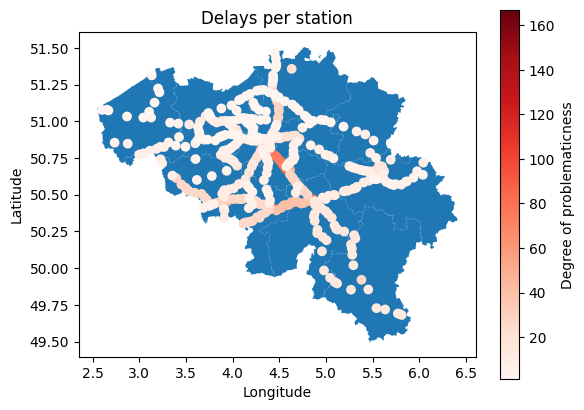

In [79]:
# problematic_routes_stops_df_merged = problematic_routes_stops_df_merged.head(100)
fig, ax = plt.subplots()
provinces.plot(ax=ax)
ax.scatter(problematic_routes_stops_df_merged["longitude"], problematic_routes_stops_df_merged["latitude"],c = problematic_routes_stops_df_merged["count"], cmap = "Reds")
sm = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=problematic_routes_stops_df_merged["count"].min(), vmax=problematic_routes_stops_df_merged["count"].max()))
sm._A = []
cbar = fig.colorbar(sm)
cbar.set_label("Degree of problematicness")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Delays per station")
plt.show()

